In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings("ignore")


In [2]:
file_path = "exchange_rate.csv"  
df = pd.read_csv(file_path, parse_dates=[0])

In [3]:
print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB
None

First 5 rows:
               date  Ex_rate
0  01-01-1990 00:00   0.7855
1  02-01-1990 00:00   0.7818
2  03-01-1990 00:00   0.7867
3  04-01-1990 00:00   0.7860
4  05-01-1990 00:00   0.7849


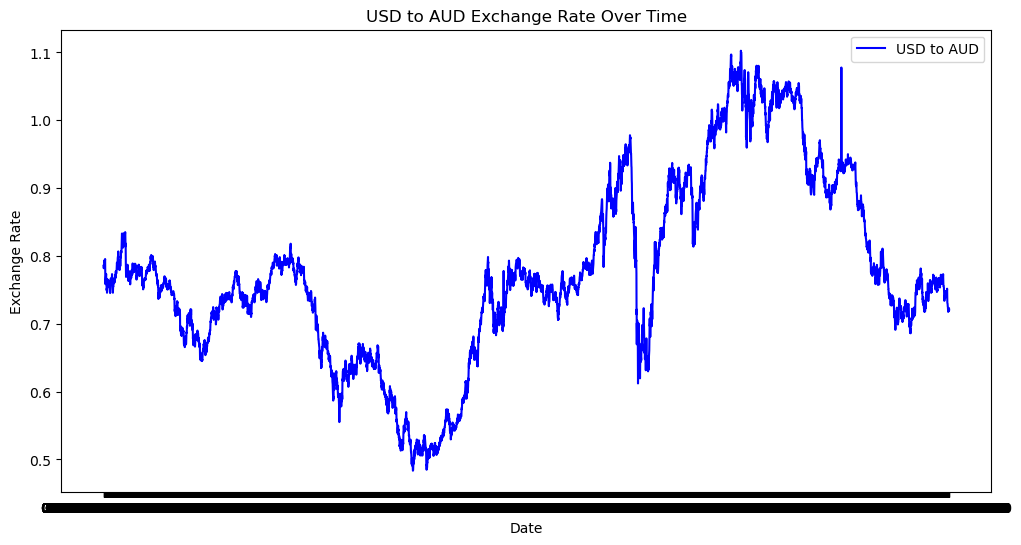

In [4]:
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['Ex_rate'], label="USD to AUD", color='blue')
plt.title("USD to AUD Exchange Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.show()

In [5]:
print("\nMissing Values:")
print(df.isnull().sum())

# Step 6: Summary statistics
print("\nSummary Statistics:")
print(df['Ex_rate'].describe())


Missing Values:
date       0
Ex_rate    0
dtype: int64

Summary Statistics:
count    7588.000000
mean        0.776974
std         0.136620
min         0.483297
25%         0.701422
50%         0.761377
75%         0.873477
max         1.102536
Name: Ex_rate, dtype: float64


In [6]:
plt.rcParams['figure.figsize'] = (12,5)

In [7]:
file_path = "exchange_rate.csv"  # change if needed
df = pd.read_csv(file_path, parse_dates=[0])
df = df.rename(columns={df.columns[0]:'date', df.columns[1]:'Ex_rate'})  # ensure columns
df = df.set_index('date').sort_index()

# quick view
display(df.head())
print("\nDataset range:", df.index.min(), "to", df.index.max())

,Ex_rate
date,
01-01-1990 00:00,0.7855
01-01-1991 00:00,0.7645
01-01-1992 00:00,0.6720
01-01-1993 00:00,0.7403
01-01-1994 00:00,0.7350



Dataset range: 01-01-1990 00:00 to 31-12-2009 00:00


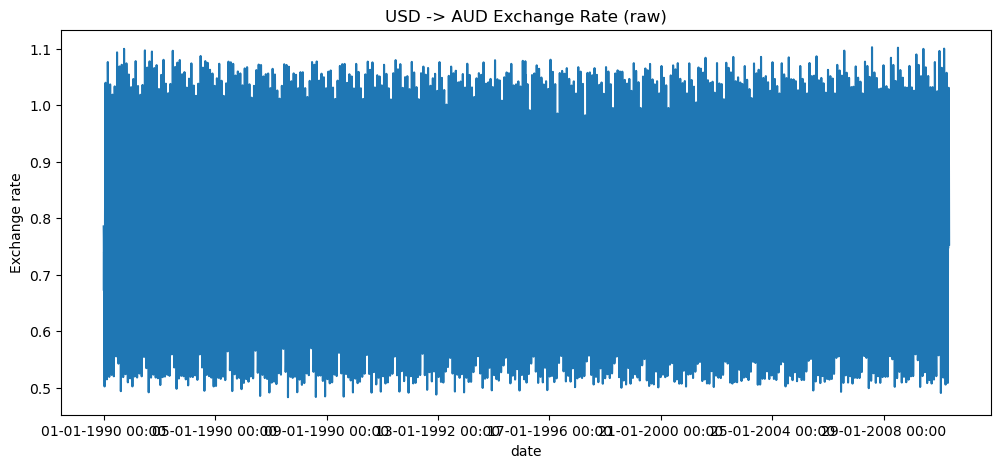

ADF statistic: -14.438089479961617
p-value: 7.437614382253839e-27
Critical values: {'1%': np.float64(-3.43121631233081), '5%': np.float64(-2.8619228448447456), '10%': np.float64(-2.566973783870177)}


In [8]:
df['Ex_rate'].plot(title="USD -> AUD Exchange Rate (raw)", ylabel="Exchange rate")
plt.show()

# ADF test
def adf_test(series, autolag='AIC'):
    res = adfuller(series.dropna(), autolag=autolag)
    out = {
        'adf_stat': res[0],
        'pvalue': res[1],
        'usedlag': res[2],
        'nobs': res[3],
        'crit_vals': res[4]
    }
    return out

adf_res = adf_test(df['Ex_rate'])
print("ADF statistic:", adf_res['adf_stat'])
print("p-value:", adf_res['pvalue'])
print("Critical values:", adf_res['crit_vals'])

After 1st difference -> ADF p-value: 0.0


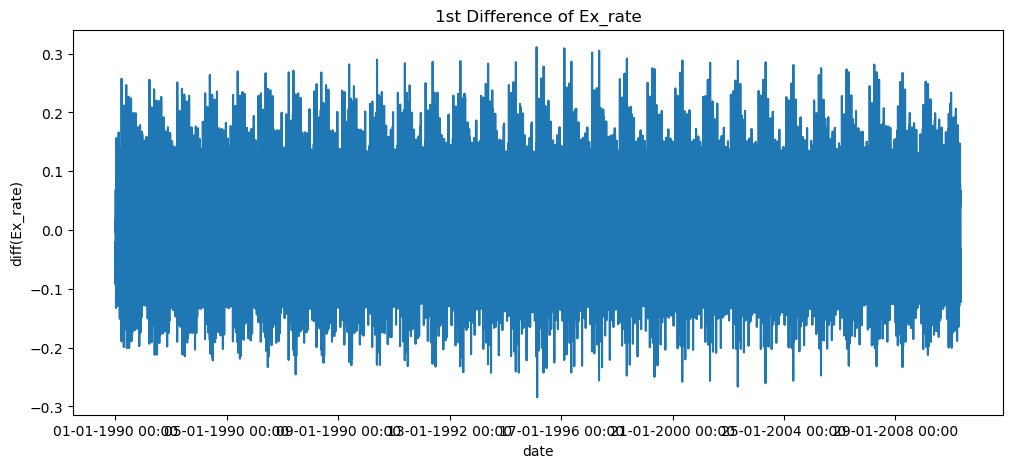

In [9]:
df['Ex_rate_diff1'] = df['Ex_rate'].diff()
adf_res_d1 = adf_test(df['Ex_rate_diff1'].dropna())
print("After 1st difference -> ADF p-value:", adf_res_d1['pvalue'])
df['Ex_rate_diff1'].plot(title='1st Difference of Ex_rate', ylabel='diff(Ex_rate)')
plt.show()

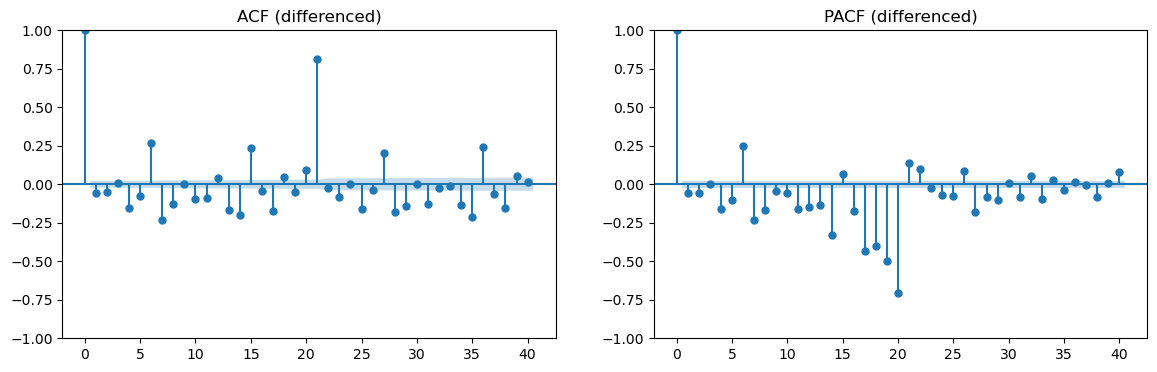

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


d = 1  
if d == 0:
    series_for_acf = df['Ex_rate'].dropna()
else:
    series_for_acf = df['Ex_rate'].diff(d).dropna()


fig, axes = plt.subplots(1,2,figsize=(14,4))
plot_acf(series_for_acf, lags=40, ax=axes[0])
axes[0].set_title('ACF (differenced)' if d>0 else 'ACF (original)')
plot_pacf(series_for_acf, lags=40, ax=axes[1], method='ywm')
axes[1].set_title('PACF (differenced)' if d>0 else 'PACF (original)')
plt.show()

In [11]:
n_test = 365
if len(df) <= n_test:
    # If dataset is small use last 12 observations
    n_test = max(12, int(len(df)*0.2))

train = df['Ex_rate'][:-n_test].dropna()
test  = df['Ex_rate'][-n_test:].dropna()

print("Train length:", len(train), "Test length:", len(test))

Train length: 7223 Test length: 365


In [12]:
def fit_arima_and_report(order, train_series, enforce_stationarity=False, enforce_invertibility=False):
    try:
        model = ARIMA(train_series, order=order, enforce_stationarity=enforce_stationarity,
                      enforce_invertibility=enforce_invertibility)
        res = model.fit()
        return {'order': order, 'aic': res.aic, 'bic': res.bic, 'model_res': res}
    except Exception as e:
        return {'order': order, 'error': str(e)}

In [13]:
p_candidates = [0,1,2,3]
q_candidates = [0,1,2,3]
d = 1  # from ADF check above; set appropriately

candidates = []
for p in p_candidates:
    for q in q_candidates:
        # skip trivial (0,0) unless needed
        if p==0 and q==0:
            continue
        candidates.append((p,d,q))

In [14]:
results = []
for order in candidates:
    print("Fitting ARIMA", order)
    r = fit_arima_and_report(order, train)
    results.append(r)

Fitting ARIMA (0, 1, 1)
Fitting ARIMA (0, 1, 2)
Fitting ARIMA (0, 1, 3)
Fitting ARIMA (1, 1, 0)
Fitting ARIMA (1, 1, 1)
Fitting ARIMA (1, 1, 2)
Fitting ARIMA (1, 1, 3)
Fitting ARIMA (2, 1, 0)
Fitting ARIMA (2, 1, 1)
Fitting ARIMA (2, 1, 2)
Fitting ARIMA (2, 1, 3)
Fitting ARIMA (3, 1, 0)
Fitting ARIMA (3, 1, 1)
Fitting ARIMA (3, 1, 2)
Fitting ARIMA (3, 1, 3)


In [15]:
valid_results = [r for r in results if 'model_res' in r]
sorted_by_aic = sorted(valid_results, key=lambda x: x['aic'])
sorted_by_aic[:5]

[{'order': (2, 1, 3),
  'aic': np.float64(-14004.82360225008),
  'bic': np.float64(-13963.517603138864),
  'model_res': <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x20a92126a80>},
 {'order': (3, 1, 3),
  'aic': np.float64(-14004.09053547491),
  'bic': np.float64(-13955.900203178491),
  'model_res': <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x20a9ea38050>},
 {'order': (3, 1, 2),
  'aic': np.float64(-13949.276897715707),
  'bic': np.float64(-13907.970067406872),
  'model_res': <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x20a9217b690>},
 {'order': (3, 1, 1),
  'aic': np.float64(-13925.29704194843),
  'bic': np.float64(-13890.874683357733),
  'model_res': <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x20a9217ba10>},
 {'order': (1, 1, 2),
  'aic': np.float64(-13851.613047675944),
  'bic': np.float64(-13824.075160803388),
  'model_res': <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x20a9214ee70>}]

In [16]:
if len(sorted_by_aic) > 0:
    best = sorted_by_aic[0]
    print("Selected order (by AIC):", best['order'], "AIC:", best['aic'])
    best_res = best['model_res']
else:
    print("No candidate ARIMA fitted successfully; trying a fallback ARIMA(1,d,1).")
    fallback = fit_arima_and_report((1,d,1), train)
    if 'model_res' in fallback:
        best_res = fallback['model_res']
        print("Fallback fitted: (1,d,1) AIC:", best_res.aic)
    else:
        raise RuntimeError("ARIMA fitting failed for all candidates. See errors:", results)

Selected order (by AIC): (2, 1, 3) AIC: -14004.82360225008


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7223
Model:                 ARIMA(2, 1, 3)   Log Likelihood                7008.412
Date:                Mon, 29 Sep 2025   AIC                         -14004.824
Time:                        10:31:00   BIC                         -13963.518
Sample:                             0   HQIC                        -13990.612
                               - 7223                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9739      0.003   -327.754      0.000      -0.980      -0.968
ar.L2         -0.9804      0.003   -349.691      0.000      -0.986      -0.975
ma.L1          0.9906      0.012     81.378      0.0

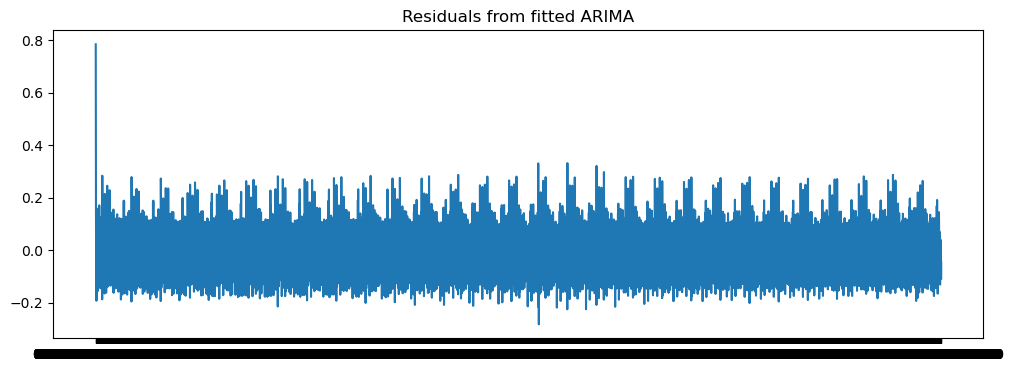

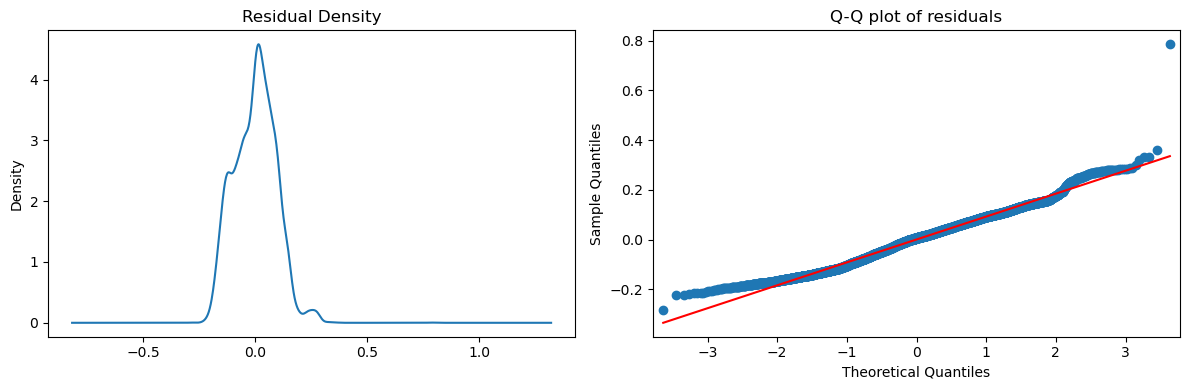

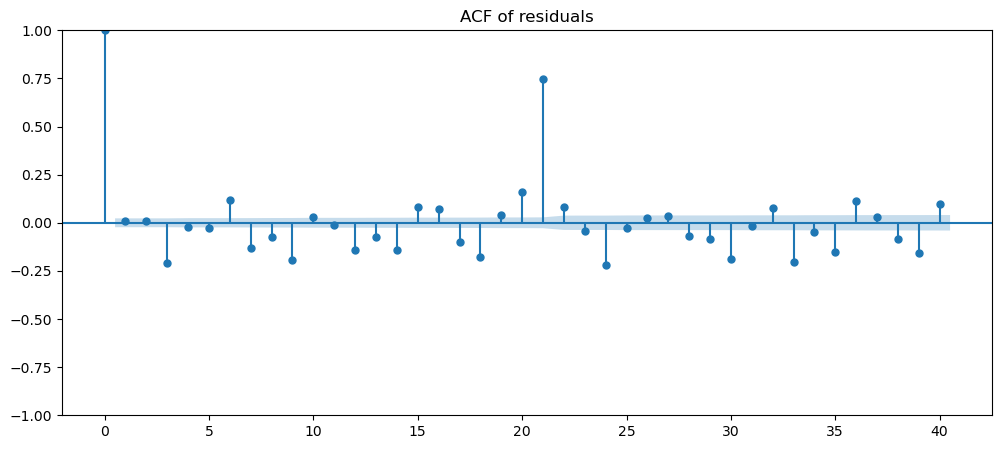

Ljung-Box test:
         lb_stat      lb_pvalue
10   871.776936  7.539253e-181
20  1790.756054   0.000000e+00


In [17]:
print(best_res.summary())

# Residuals
resid = best_res.resid
plt.figure(figsize=(12,4))
plt.plot(resid)
plt.title("Residuals from fitted ARIMA")
plt.show()

# Residual density and qqplot
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
resid.plot(kind='kde', title='Residual Density')
plt.subplot(1,2,2)
import statsmodels.api as sm
sm.qqplot(resid, line='s', ax=plt.gca())
plt.title('Q-Q plot of residuals')
plt.tight_layout()
plt.show()

# ACF of residuals
plot_acf(resid.dropna(), lags=40)
plt.title("ACF of residuals")
plt.show()

# Ljung-Box test for no autocorrelation
lb_test = acorr_ljungbox(resid.dropna(), lags=[10, 20], return_df=True)
print("Ljung-Box test:\n", lb_test)

In [18]:
steps = len(test)
fc = best_res.get_forecast(steps=steps)
pred = fc.predicted_mean
conf_int = fc.conf_int()


pred.index = test.index
conf_int.index = test.index

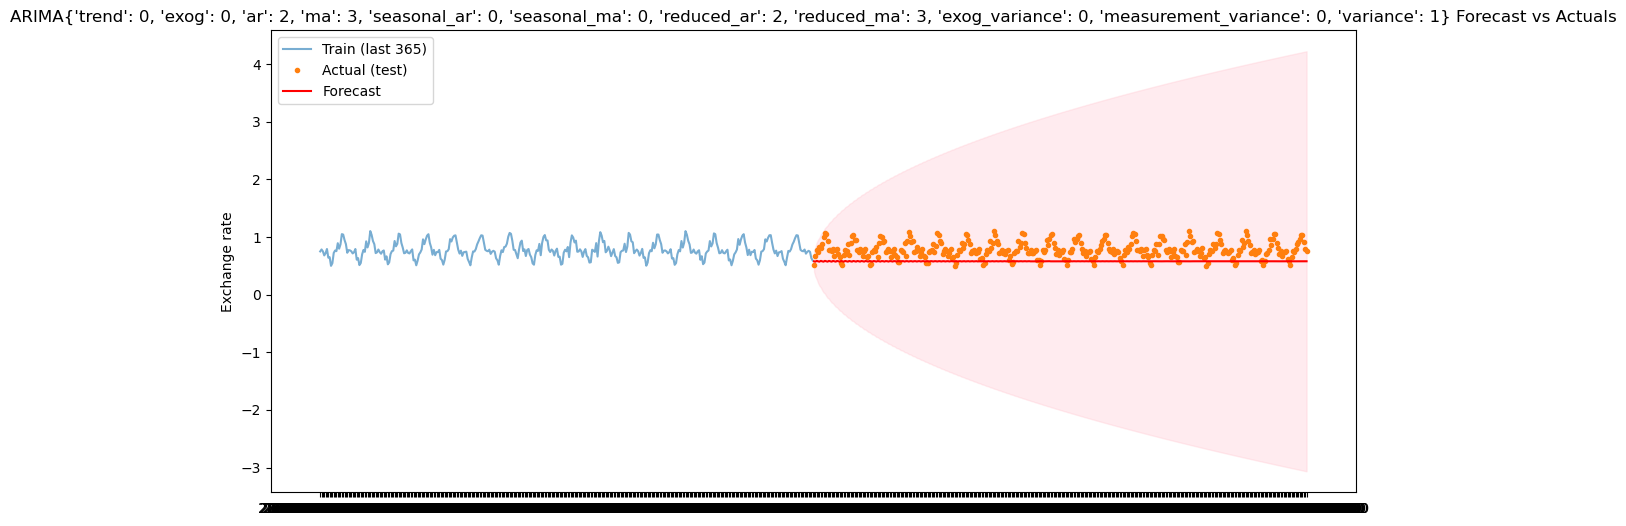

In [19]:
plt.figure(figsize=(14,6))
plt.plot(train.index[-365:], train.iloc[-365:], label='Train (last 365)', alpha=0.6)
plt.plot(test.index, test, label='Actual (test)', marker='.', linestyle='none')
plt.plot(pred.index, pred, label='Forecast', color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink', alpha=0.3)
plt.legend()
plt.title(f'ARIMA{best_res.model_orders} Forecast vs Actuals')
plt.ylabel('Exchange rate')
plt.show()

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, pred)
# Calculate MSE first, then take the square root to get RMSE
mse = mean_squared_error(test, pred)
rmse = np.sqrt(mse)  # Manually calculate RMSE instead of using squared=False

print(f"MAE: {mae:.6f}, RMSE: {rmse:.6f}")

MAE: 0.209298, RMSE: 0.245054


In [21]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Helper function for evaluation
def evaluate_forecast(y_true, y_pred, label="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    print(f"{label} -> MAE: {mae:.6f}, RMSE: {rmse:.6f}")
    return mae, rmse

In [22]:



ses_model = SimpleExpSmoothing(train).fit(optimized=True)  # or use fit() without parameters
ses_forecast = ses_model.forecast(len(test))


def evaluate_forecast(actual, forecast, model_name):
    # Calculate error metrics without using 'squared' parameter
    import numpy as np
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    
    mse = mean_squared_error(actual, forecast)  # Don't use squared=True/False here
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, forecast)
    
    print(f"{model_name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# Now call the function
evaluate_forecast(test, ses_forecast, "Simple Exp Smoothing")

Simple Exp Smoothing - RMSE: 0.2319, MAE: 0.1960


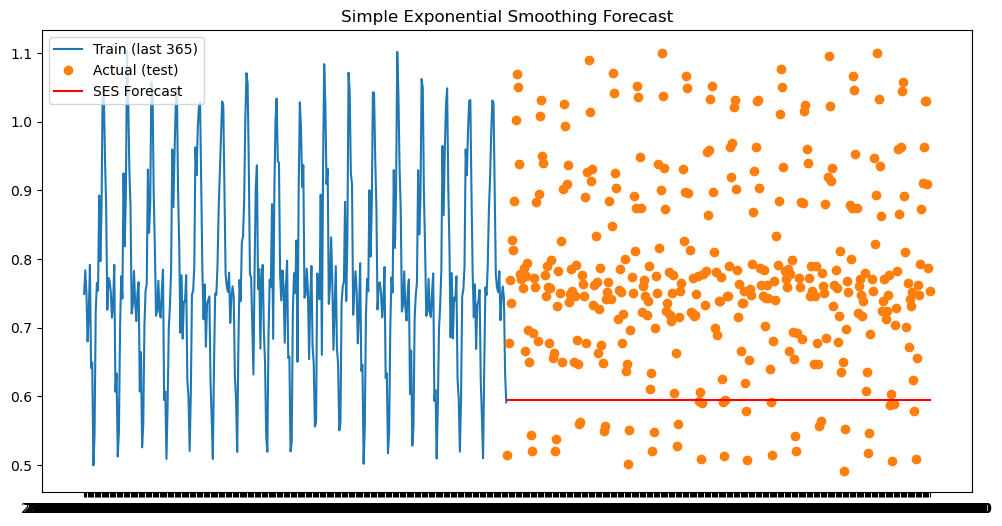

In [23]:
plt.figure(figsize=(12,6))
plt.plot(train.index[-365:], train[-365:], label="Train (last 365)")
plt.plot(test.index, test, label="Actual (test)", marker="o", linestyle="none")
plt.plot(test.index, ses_forecast, label="SES Forecast", color="red")
plt.title("Simple Exponential Smoothing Forecast")
plt.legend()
plt.show()

Holt’s Linear Trend - RMSE: 0.2875, MAE: 0.2517


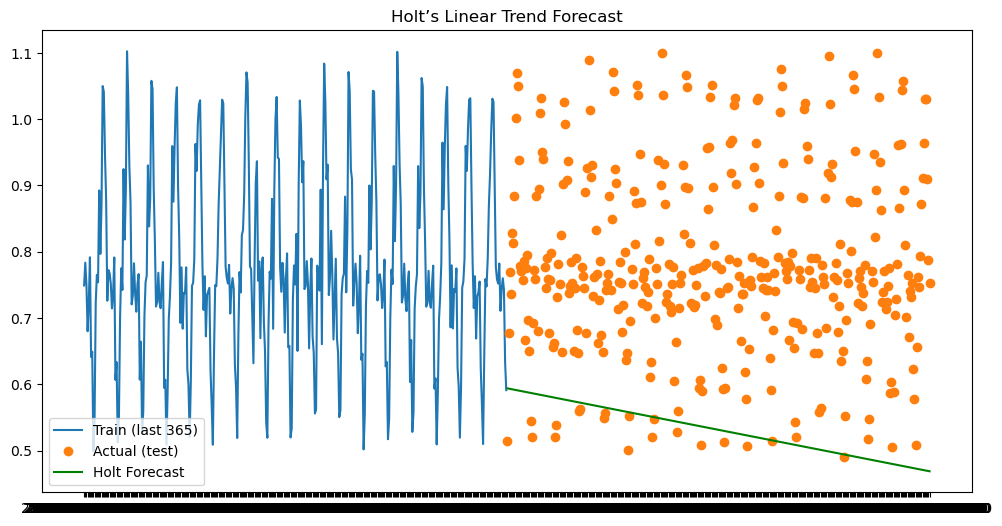

In [24]:
holt_model = Holt(train).fit(optimized=True)
holt_forecast = holt_model.forecast(len(test))
evaluate_forecast(test, holt_forecast, "Holt’s Linear Trend")

plt.figure(figsize=(12,6))
plt.plot(train.index[-365:], train[-365:], label="Train (last 365)")
plt.plot(test.index, test, label="Actual (test)", marker="o", linestyle="none")
plt.plot(test.index, holt_forecast, label="Holt Forecast", color="green")
plt.title("Holt’s Linear Trend Forecast")
plt.legend()
plt.show()

Holt-Winters (Additive) - RMSE: 0.2397, MAE: 0.2037
Holt-Winters (Multiplicative) - RMSE: 0.4525, MAE: 0.4117


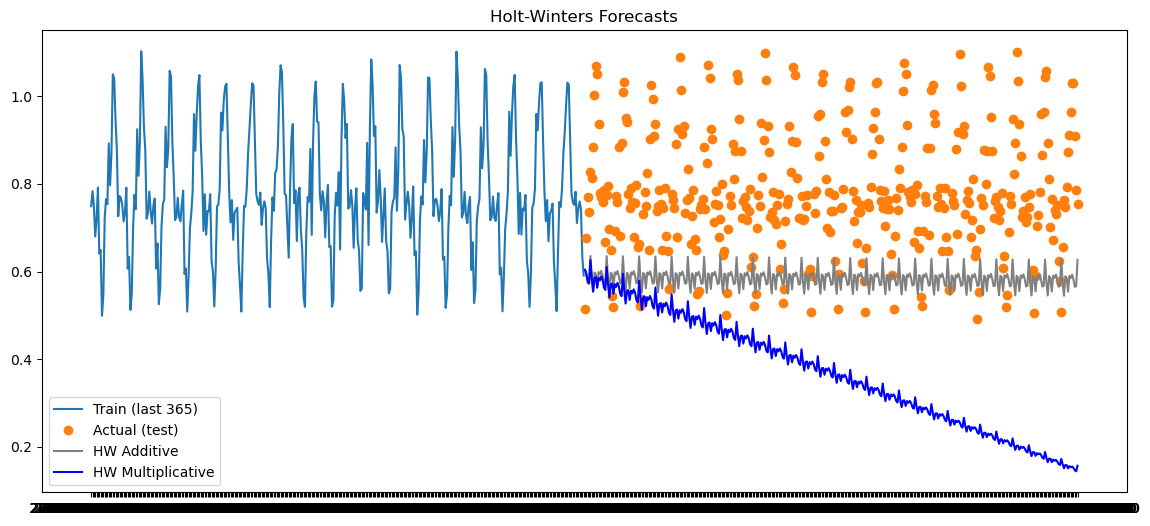

In [31]:
seasonal_periods = 12  # adjust if your data is not monthly

# Additive
hw_add = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=seasonal_periods).fit(optimized=True)
hw_add_forecast = hw_add.forecast(len(test))
evaluate_forecast(test, hw_add_forecast, "Holt-Winters (Additive)")

# Multiplicative
hw_mul = ExponentialSmoothing(train, trend="add", seasonal="mul", seasonal_periods=seasonal_periods).fit(optimized=True)
hw_mul_forecast = hw_mul.forecast(len(test))
evaluate_forecast(test, hw_mul_forecast, "Holt-Winters (Multiplicative)")

# Plot comparison
plt.figure(figsize=(14,6))
plt.plot(train.index[-365:], train[-365:], label="Train (last 365)")
plt.plot(test.index, test, label="Actual (test)", marker="o", linestyle="none")
plt.plot(test.index, hw_add_forecast, label="HW Additive", color="gray")
plt.plot(test.index, hw_mul_forecast, label="HW Multiplicative", color="blue")
plt.title("Holt-Winters Forecasts")
plt.legend()
plt.show()

In [26]:
results = {
    "SES": evaluate_forecast(test, ses_forecast, "SES"),
    "Holt": evaluate_forecast(test, holt_forecast, "Holt"),
    "HW Add": evaluate_forecast(test, hw_add_forecast, "Holt-Winters Add"),
    "HW Mul": evaluate_forecast(test, hw_mul_forecast, "Holt-Winters Mul"),
}

results_df = pd.DataFrame(results, index=["MAE","RMSE"]).T
results_df



SES - RMSE: 0.2319, MAE: 0.1960
Holt - RMSE: 0.2875, MAE: 0.2517
Holt-Winters Add - RMSE: 0.2397, MAE: 0.2037
Holt-Winters Mul - RMSE: 0.4525, MAE: 0.4117


,MAE,RMSE
SES,None,None
Holt,None,None
HW Add,None,None
HW Mul,None,None


In [27]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Collect forecasts into dictionary
forecast_results = {
    "ARIMA": pred,
    "SES": ses_forecast,
    "Holt": holt_forecast,
    "HW Add": hw_add_forecast,
    "HW Mul": hw_mul_forecast,
}

In [29]:

metrics = {}
for name, yhat in forecast_results.items():
    mae = mean_absolute_error(test, yhat)
    # Calculate RMSE manually by taking the square root of MSE
    mse = mean_squared_error(test, yhat)
    rmse = np.sqrt(mse)  # Calculate RMSE manually
    mape = mean_absolute_percentage_error(test, yhat)
    metrics[name] = {"MAE": mae, "RMSE": rmse, "MAPE": mape}

metrics_df = pd.DataFrame(metrics).T
metrics_df

,MAE,RMSE,MAPE
ARIMA,0.209298,0.245054,24.858562
SES,0.196040,0.231942,23.255495
Holt,0.251679,0.287457,30.189708
HW Add,0.203700,0.239699,24.192878
HW Mul,0.411684,0.452456,51.283632
